# Titanic 生存预测
    1.数据分析
    2.特征工程
    3.模型选择
    4.模型融合
    5.输出结果

## 导入包

In [176]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import log_loss
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# hold-out
from sklearn.model_selection import train_test_split
# K折交叉验证
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
# K折分布保持交叉验证
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
# booststrap 采样
from sklearn.utils import resample

# 1.数据分析

### 加载数据

In [190]:
data_train=pd.read_csv('train1.csv')
data_val= pd.read_csv('test1.csv')
data=data_train.copy(deep = True)#创建副本
data_train.info()
data_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass  

#### 训练集891个数据，其中Cabin,Age,Embarked有缺失，测试集数据418个，其中Age,Cabin,Fare有缺失

In [191]:
#将测试集和训练集合并，方便一起处理数据
data_cleaner = pd.concat([data, data_val],axis=0)
data_cleaner.index=data_cleaner['PassengerId']
#data_cleaner=[data, data_val]
data_train.sample(6)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
292,293,0,2,"Levy, Mr. Rene Jacques",male,36.0,0,0,SC/Paris 2163,12.8750,D,C
177,178,0,1,"Isham, Miss. Ann Elizabeth",female,50.0,0,0,PC 17595,28.7125,C49,C
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
350,351,0,3,"Odahl, Mr. Nils Martin",male,23.0,0,0,7267,9.2250,NaN,S
611,612,0,3,"Jardin, Mr. Jose Neto",male,NaN,0,0,SOTON/O.Q. 3101305,7.0500,NaN,S
155,156,0,1,"Williams, Mr. Charles Duane",male,51.0,0,1,PC 17597,61.3792,NaN,C


In [19]:
print('训练数据缺失情况:\n', data.isnull().sum())
print("-"*10)

print('验证数据缺失情况:\n', data_val.isnull().sum())
print("-"*10)

data_train.describe(include = 'all')

训练数据缺失情况:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
----------
验证数据缺失情况:
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64
----------


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Ball, Mrs. (Ada E Hall)",male,NaN,NaN,NaN,CA. 2343,NaN,G6,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


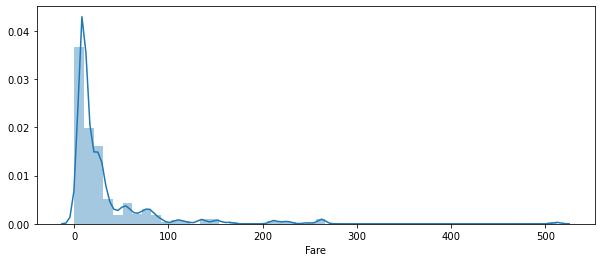

In [163]:
plt.figure(figsize=(10,4))
sns.distplot(data_cleaner['Fare'])
plt.show()

### 分析变量
    1.PassengerId 相当于个人ID，可以当作主键处理，Survived是我们要预测的，作为y
    2.Pclass代表舱位等级，Embraked代表上船地点，Sex性别，Sibsp兄弟姐妹或配偶的数量，Parch为父母或孩子的数量，Ticket为船票的号码，Fare为票价，Cabin为船舱
    3.发现有很多人共用一张票，票的编号Ticket一样，导致了Fare是总价，Fare很高，考虑是否需要平均处理。
    4.Sex性别进行0,1编码分类处理
    5.Name为字符型，但是其前缀Mr,Mrs,Master暗含年龄和性别，考虑进行处理
    6.Cabin缺失太多，且前面的字母似乎与Pclass关系不大，后面将剔除这个变量
    7.Age缺失20%左右，进行中位数插补
    8.SibSp和Parch其实都代表这个人是否单独坐船，考虑合并
    9.Embarked进行编码处理

## 2.特征工程
    在这一阶段，我们将通过以下方式清理数据：
    1）纠正异常值和离群值
    2）补充缺失的信息
    3）创建新的特征
    4）将字段转换为可计算、可展示的格式。

### 2.1 填补缺失值

In [192]:
#处理变量Fare
fare_median=data_cleaner.Fare.median()
data_cleaner.Fare.fillna(fare_median,inplace=True)
data1=data_cleaner.groupby('Ticket')['Fare'].count()
data2=data_cleaner.groupby('Ticket')['Fare'].max()
df=pd.concat([data1,data2],axis=1)
df.columns=list(['a','b'])
df['Ticket1']=data1.index
df['avgFare']=df.apply(lambda x:x['b']/x['a'],axis=1)
df1=df.loc[:,['Ticket1','avgFare']]
data_cleaner=pd.merge(data_cleaner,df1,left_on='Ticket',how='outer',right_index=True)
data_cleaner['avgFare']=np.log(data_cleaner['avgFare']+1)

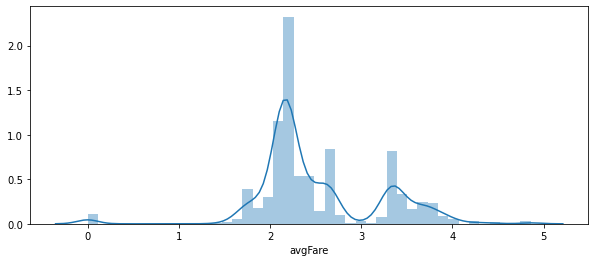

In [193]:
plt.figure(figsize=(10,4))
sns.distplot(data_cleaner['avgFare'])
plt.show()

In [194]:
#删去Ticket1PassengerId,Cabin
data_cleaner=data_cleaner.sort_index(axis=0)
data_cleaner.drop(['Ticket1','Cabin','Ticket'],axis=1, inplace = True)

In [195]:
#Age
#中位数插补，以其他class为索引，分层插补
#分组计算中位数
age_median=data_cleaner.groupby(['Pclass','Sex','Embarked']).Age.median()
#创建新索引
data_cleaner.set_index(['Pclass','Sex','Embarked'],inplace=True)
#填充
data_cleaner.Age.fillna(age_median,inplace=True)
data_cleaner.reset_index(inplace=True)
data_cleaner=data_cleaner.sort_index(axis=0)

In [196]:
#Embarked填充，并创建新特征
data=data_cleaner.iloc[:891,:]
data_val=data_cleaner.iloc[891:,]
data_cleaner=[data,data_val]
for dataset in data_cleaner:    
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace = True)
    dataset['FamilySize'] = dataset ['SibSp'] + dataset['Parch'] + 1
    dataset['IsAlone'] = 1 
    dataset['IsAlone'].loc[dataset['FamilySize'] > 1] = 0 
    dataset['Title'] = dataset['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
    #dataset['FareBin'] = pd.qcut(dataset['Fare'], 4)
    dataset['AgeBin'] = pd.cut(dataset['Age'].astype(int), 5)

C:\jupy\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


#### 对清理后的数据进行编码

In [198]:
#编码处理
title_names = (data['Title'].value_counts() < 10)
data['Title']=data['Title'].apply(lambda x: 'Mc' if title_names.loc[x]==True else x)
print(data['Title'].value_counts())
label = LabelEncoder()
for dataset in data_cleaner:    
    dataset['Sex_Code'] = label.fit_transform(dataset['Sex'])
    dataset['Embarked_Code'] = label.fit_transform(dataset['Embarked'])
    dataset['Title_Code'] = label.fit_transform(dataset['Title'])
    dataset['AgeBin_Code'] = label.fit_transform(dataset['AgeBin'])

Mr        517
Miss      182
Mrs       125
Master     40
Mc         27
Name: Title, dtype: int64


In [207]:
target=['Survived']
features_to_use=['Pclass','avgFare','IsAlone','Sex_Code','Embarked_Code','Title_Code','AgeBin_Code']

#### 检查清理后的数据

In [202]:
data.info()
print('——'*10)
data_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Pclass         891 non-null    int64   
 1   Sex            891 non-null    object  
 2   Embarked       891 non-null    object  
 3   PassengerId    891 non-null    int64   
 4   Survived       891 non-null    float64 
 5   Name           891 non-null    object  
 6   Age            891 non-null    float64 
 7   SibSp          891 non-null    int64   
 8   Parch          891 non-null    int64   
 9   Fare           891 non-null    float64 
 10  avgFare        891 non-null    float64 
 11  FamilySize     891 non-null    int64   
 12  IsAlone        891 non-null    int64   
 13  Title          891 non-null    object  
 14  AgeBin         891 non-null    category
 15  Sex_Code       891 non-null    int32   
 16  Embarked_Code  891 non-null    int32   
 17  Title_Code     891 non-null    int3

In [205]:
data[features_to_use]

,Pclass,avgFare,IsAlone,Sex_Code,Embarked_Code,Title_Code,AgeBin_Code
0,3,2.110213,0,1,2,3,1
1,1,3.601186,0,0,0,4,2
2,3,2.188856,1,0,2,2,1
3,1,3.316003,0,0,2,4,2
4,3,2.202765,1,1,2,3,2
...,...,...,...,...,...,...,...
886,2,2.639057,1,1,2,1,1
887,1,3.433987,1,0,2,2,1
888,3,1.926072,0,0,2,2,1
889,1,3.433987,1,1,0,3,1


#### 切分数据集

In [208]:
train_x,test_x,train_y,test_y=train_test_split(data[features_to_use],data[target],test_size=0.2,random_state=0)

In [242]:
for i in data[features_to_use]:
    if data[i].dtype!='float64':
        print('死亡率：',i)
        print(data[[i,target[0]]].groupby(i,as_index=False).mean())
        print('——'*10)

死亡率： Pclass
   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363
————————————————————
死亡率： IsAlone
   IsAlone  Survived
0        0  0.505650
1        1  0.303538
————————————————————
死亡率： Sex_Code
   Sex_Code  Survived
0         0  0.742038
1         1  0.188908
————————————————————
死亡率： Embarked_Code
   Embarked_Code  Survived
0              0  0.553571
1              1  0.389610
2              2  0.339009
————————————————————
死亡率： Title_Code
   Title_Code  Survived
0           0  0.575000
1           1  0.444444
2           2  0.697802
3           3  0.156673
4           4  0.792000
————————————————————
死亡率： AgeBin_Code
   AgeBin_Code  Survived
0            0  0.551402
1            1  0.334016
2            2  0.412037
3            3  0.434783
4            4  0.090909
————————————————————


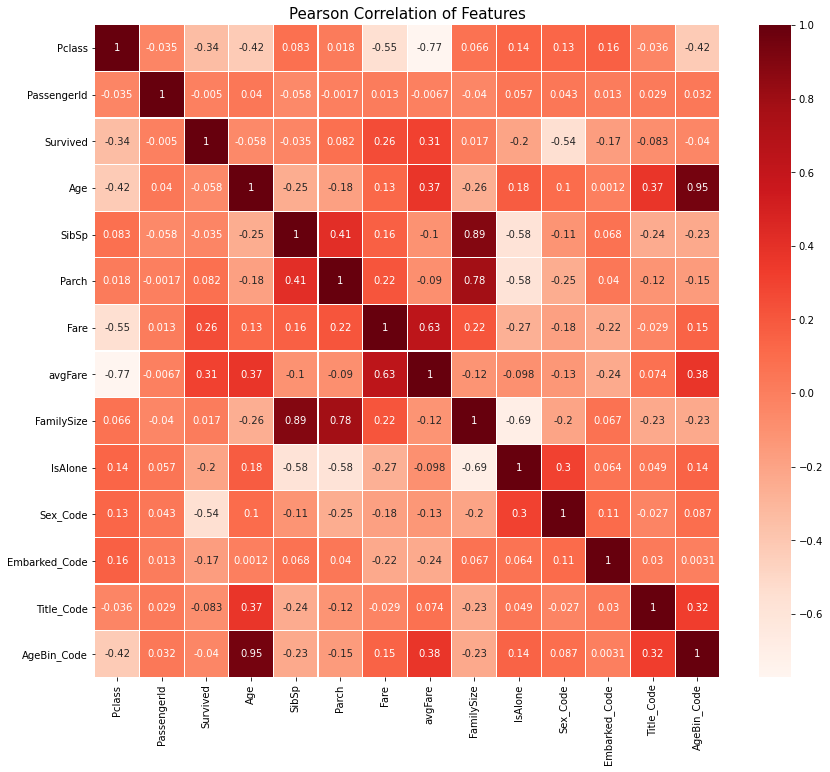

In [226]:
fig,ax=plt.subplots(figsize=(14,12))
fig=sns.heatmap(data.corr(),cmap='Reds',ax=ax,annot=True,linewidths=0.1,linecolor='white')
plt.title('Pearson Correlation of Features',size=15)
plt.show()

# 3.建模 

In [249]:
clf = XGBClassifier()
clf.fit(data[features_to_use], data[target])
pre_test=clf.predict(data_val[features_to_use])

submission=pd.DataFrame({'PassengerId':data_val['PassengerId'].astype(int),'Survived':pre_test.astype(int)})
submission.to_csv('submission.csv',index=False)

In [252]:
l1=pd.read_csv('submission.csv')
l1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   PassengerId  418 non-null    int64
 1   Survived     418 non-null    int64
dtypes: int64(2)
memory usage: 6.7 KB


In [260]:
clf = RandomForestClassifier()
clf.fit(data[features_to_use], data[target])
pre_test=clf.predict(data_val[features_to_use])

submission=pd.DataFrame({'PassengerId':data_val['PassengerId'].astype(int),'Survived':pre_test.astype(int)})
submission.to_csv('submission.csv',index=False)